In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Neural_Tangent_Kernel/

/content/drive/MyDrive/Neural_Tangent_Kernel


In [3]:
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt


from myrmsprop import MyRmsprop
from utils import plot_decision_boundary,attn_avg,plot_analysis
from synthetic_dataset import MosaicDataset1
from eval_model import calculate_attn_loss,analyse_data



%matplotlib inline
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
train_data = np.load("train_type4_data.npy",allow_pickle=True)

test_data = np.load("test_type4_data.npy",allow_pickle=True)

In [5]:
mosaic_list_of_images = train_data[0]["mosaic_list"]
mosaic_label = train_data[0]["mosaic_label"]
fore_idx = train_data[0]["fore_idx"]


test_mosaic_list_of_images = test_data[0]["mosaic_list"]
test_mosaic_label = test_data[0]["mosaic_label"]
test_fore_idx = test_data[0]["fore_idx"]

In [6]:
batch = 3000
train_dataset = MosaicDataset1(mosaic_list_of_images, mosaic_label, fore_idx)
train_loader = DataLoader( train_dataset,batch_size= batch ,shuffle=False)
#batch = 2000
#test_dataset = MosaicDataset1(test_mosaic_list_of_images, test_mosaic_label, test_fore_idx)
#test_loader = DataLoader(test_dataset,batch_size= batch ,shuffle=False)

# NTK

In [7]:
data = np.load("NTK_1.npy",allow_pickle=True)
# H = data[0]

In [8]:
print(data[0].keys())
H = torch.tensor(data[0]["NTK"])

dict_keys(['NTK'])


In [9]:
lr_1 = 1/1470559.2


In [10]:
# p_vec = nn.utils.parameters_to_vector(where_func.parameters())
# p, = p_vec.shape
# n_m, n_obj,_ = inputs.shape  # number of mosaic images x number of objects in each mosaic  x d
# # this is the transpose jacobian (grad y(w))^T)
# features = torch.zeros(n_m*n_obj, p, requires_grad=False)
 
# k = 0 


# for i in range(27000):
#     out = where_func(inpp[i])
#     where_func.zero_grad()
#     out.backward(retain_graph=False)
#     p_grad = torch.tensor([], requires_grad=False)
#     for p in where_func.parameters():
#       p_grad = torch.cat((p_grad, p.grad.reshape(-1)))
#     features[k,:] = p_grad
#     k = k+1
# tangent_kernel =  features@features.T

In [11]:
# class Module1(nn.Module):
#   def __init__(self):
#     super(Module1, self).__init__()
#     self.linear1 = nn.Linear(2,100)
#     self.linear2 = nn.Linear(100,1)

#   def forward(self,x):
#     x = F.relu(self.linear1(x))
#     x = self.linear2(x)
#     return x

In [12]:
# from tqdm import tqdm as tqdm

In [13]:
# inputs,_,_ = iter(train_loader).next()
# inputs = torch.reshape(inputs,(27000,2))
# inputs = (inputs - torch.mean(inputs,dim=0,keepdims=True) )/torch.std(inputs,dim=0,keepdims=True)
# where_net = Module1()
# outputs = where_net(inputs)


In [14]:
# feature1 = torch.zeros((27000,200))
# feature2  = torch.zeros((27000,100))
# for i in tqdm(range(27000)):
#   where_net.zero_grad()
#   outputs[i].backward(retain_graph=True)
#   par = []
#   j = 0
#   for p in where_net.parameters():
#     if j%2 == 0:
#       vec = torch.nn.utils.parameters_to_vector(p)
#       p_grad = p.grad.reshape(-1)
#       par.append(p_grad)
#     j = j+1
#   feature1[i,:] = par[0]
#   feature2[i,:] = par[1]

In [15]:
# H = feature1@feature1.T + feature2@feature2.T

# Models

In [16]:
class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    self.linear1 = nn.Linear(2,100)
    self.linear2 = nn.Linear(100,3)

  def forward(self,x):
    x = F.relu(self.linear1(x))
    x = self.linear2(x)
    return x

In [17]:
print(H)

tensor([[75.1031, 35.6146, 79.1224,  ..., 63.2880, 38.2985, 72.4251],
        [35.6146, 21.1840, 42.9770,  ..., 33.6579, 25.0675, 44.2191],
        [79.1224, 42.9770, 92.8314,  ..., 73.0225, 48.9726, 88.7758],
        ...,
        [63.2880, 33.6579, 73.0225,  ..., 58.0862, 38.0167, 69.3583],
        [38.2985, 25.0675, 48.9726,  ..., 38.0167, 34.9229, 54.7437],
        [72.4251, 44.2191, 88.7758,  ..., 69.3583, 54.7437, 95.1200]])


In [18]:
torch.manual_seed(1234)
what_net = Module2().double()

what_net.load_state_dict(torch.load("type4_what_net.pt"))
what_net = what_net.to("cuda")

In [19]:
n_batches = 3000//batch
bg = []
for i in range(n_batches):
  torch.manual_seed(i)
  betag = torch.randn(3000,9)#torch.ones((250,9))/9
  bg.append( betag.requires_grad_() )

# training

In [20]:
criterion = nn.CrossEntropyLoss()

In [21]:
optim1 = []
H= H.to("cpu")
for i in range(n_batches):
  optim1.append(MyRmsprop([bg[i]],H=H,lr=1))
# instantiate what net optimizer
optimizer_what = optim.RMSprop(what_net.parameters(), lr=0.0001)#, momentum=0.9)#,nesterov=True)

In [22]:

acti = []
analysis_data_tr = []
analysis_data_tst = []
loss_curi_tr = []
loss_curi_tst = []
epochs = 2500


# calculate zeroth epoch loss and FTPT values
running_loss,anlys_data,correct,total,accuracy = calculate_attn_loss(train_loader,bg,what_net,criterion)
print('training epoch: [%d ] loss: %.3f correct: %.3f, total: %.3f, accuracy: %.3f' %(0,running_loss,correct,total,accuracy)) 
loss_curi_tr.append(running_loss)
analysis_data_tr.append(anlys_data)




# training starts 
for epoch in range(epochs): # loop over the dataset multiple times
  ep_lossi = []
  running_loss = 0.0
  what_net.train()
  for i, data in enumerate(train_loader, 0):
    # get the inputs
    inputs, labels,_  = data
    inputs = inputs.double()
    beta = bg[i] # alpha for ith batch
    #print(labels)
    inputs, labels,beta = inputs.to("cuda"),labels.to("cuda"),beta.to("cuda")
        
    # zero the parameter gradients
    optimizer_what.zero_grad()
    optim1[i].zero_grad()
      
    # forward + backward + optimize
    avg,alpha = attn_avg(inputs,beta)
    outputs = what_net(avg)     
    loss = criterion(outputs, labels)

    # print statistics
    running_loss += loss.item()
    #alpha.retain_grad()
    loss.backward(retain_graph=False)
    optimizer_what.step()
    optim1[i].step()


  running_loss_tr,anls_data,correct,total,accuracy = calculate_attn_loss(train_loader,bg,what_net,criterion)
  analysis_data_tr.append(anls_data)
  loss_curi_tr.append(running_loss_tr)   #loss per epoch
  print('training epoch: [%d ] loss: %.3f correct: %.3f, total: %.3f, accuracy: %.3f' %(epoch+1,running_loss_tr,correct,total,accuracy)) 


  
  if running_loss_tr<=0.08:
    break
print('Finished Training run ')
analysis_data_tr = np.array(analysis_data_tr)



training epoch: [0 ] loss: 10.201 correct: 1133.000, total: 3000.000, accuracy: 0.378
training epoch: [1 ] loss: 21.519 correct: 982.000, total: 3000.000, accuracy: 0.327
training epoch: [2 ] loss: 19.156 correct: 981.000, total: 3000.000, accuracy: 0.327
training epoch: [3 ] loss: 18.476 correct: 980.000, total: 3000.000, accuracy: 0.327
training epoch: [4 ] loss: 18.127 correct: 981.000, total: 3000.000, accuracy: 0.327
training epoch: [5 ] loss: 17.889 correct: 985.000, total: 3000.000, accuracy: 0.328
training epoch: [6 ] loss: 17.703 correct: 988.000, total: 3000.000, accuracy: 0.329
training epoch: [7 ] loss: 17.549 correct: 992.000, total: 3000.000, accuracy: 0.331
training epoch: [8 ] loss: 17.411 correct: 997.000, total: 3000.000, accuracy: 0.332
training epoch: [9 ] loss: 17.288 correct: 1001.000, total: 3000.000, accuracy: 0.334
training epoch: [10 ] loss: 17.176 correct: 1002.000, total: 3000.000, accuracy: 0.334
training epoch: [11 ] loss: 17.072 correct: 1002.000, total: 

In [23]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = np.arange(0,epoch+2)
df_train[columns[1]] = analysis_data_tr[:,-2]/30
df_train[columns[2]] = analysis_data_tr[:,-1]/30
df_train[columns[3]] = analysis_data_tr[:,0]/30
df_train[columns[4]] = analysis_data_tr[:,1]/30
df_train[columns[5]] = analysis_data_tr[:,2]/30
df_train[columns[6]] = analysis_data_tr[:,3]/30

In [24]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,9.800000,90.200000,5.233333,32.533333,6.533333,55.700000
1,1,59.966667,40.033333,8.966667,23.766667,0.100000,67.166667
2,2,63.166667,36.833333,12.866667,19.833333,0.166667,67.133333
3,3,64.500000,35.500000,13.700000,18.966667,0.133333,67.200000
4,4,64.800000,35.200000,13.800000,18.900000,0.100000,67.200000
...,...,...,...,...,...,...,...
2496,2496,98.666667,1.333333,0.066667,33.200000,1.766667,64.966667
2497,2497,98.666667,1.333333,0.066667,33.366667,1.766667,64.800000
2498,2498,98.666667,1.333333,0.066667,33.266667,1.766667,64.900000
2499,2499,98.666667,1.333333,0.066667,33.266667,1.766667,64.900000


/content


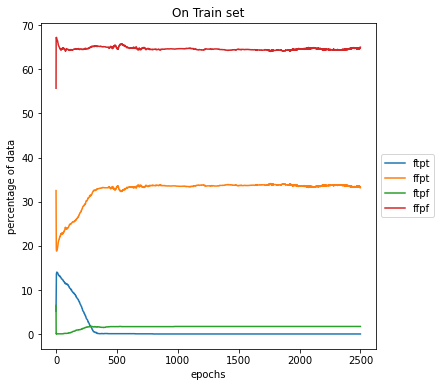

In [25]:
%cd /content/
plot_analysis(df_train,columns,[0,500,1000,1500,2000,2500])

In [26]:
aph = []
for i in bg:
  aph.append(F.softmax(i,dim=1).detach().numpy())
  
aph = np.concatenate(aph,axis=0)
# torch.save({
#             'epoch': 500,
#             'model_state_dict': what_net.state_dict(),
#             #'optimizer_state_dict': optimizer_what.state_dict(),
#             "optimizer_alpha":optim1,
#             "FTPT_analysis":analysis_data_tr,
#             "alpha":aph

#             }, "type4_what_net_500.pt")

In [27]:
aph[0]

array([9.9999940e-01, 0.0000000e+00, 9.0554377e-36, 0.0000000e+00,
       0.0000000e+00, 3.9413095e-07, 0.0000000e+00, 2.9103995e-07,
       0.0000000e+00], dtype=float32)

In [28]:
avrg = []
avrg_lbls = []
with torch.no_grad():
  for i, data1 in  enumerate(train_loader):
          inputs , labels , fore_idx = data1
          inputs = inputs.double()
          inputs = inputs.to("cuda")
          beta  = bg[i]
          beta = beta.to("cuda")
          avg,alpha = attn_avg(inputs,beta)
          
          avrg.append(avg.detach().cpu().numpy())
          avrg_lbls.append(labels.numpy())
avrg= np.concatenate(avrg,axis=0)
avrg_lbls = np.concatenate(avrg_lbls,axis=0)

/content/drive/MyDrive/Neural_Tangent_Kernel
/content


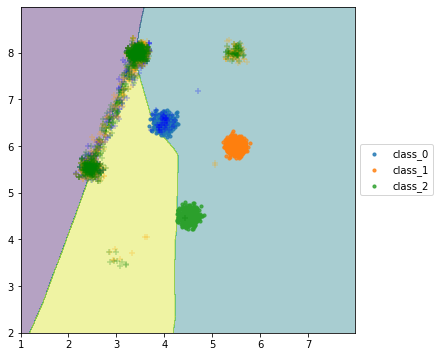

In [29]:
%cd /content/drive/MyDrive/Neural_Tangent_Kernel/
data = np.load("type_4_data.npy",allow_pickle=True)
%cd /content/
plot_decision_boundary(what_net,[1,8,2,9],data,bg,avrg,avrg_lbls)

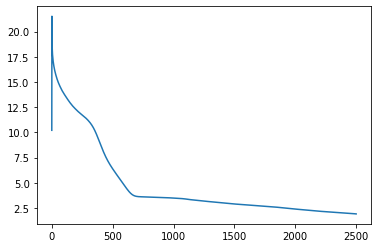

In [30]:
plt.plot(loss_curi_tr)